# Data statistics

We will both go through motion sequences and texts.
This will inform us of which we have to remove.

## Motion sequences

After get filelist: len(files) 29228
After check: shape_consistency_check 20578
After check: nan_zero_check 20567
After check: check_velocity_all 20539
['M002390', '010909', 'M001699', 'M000587', 'M001841']
Summary:
                train	val	test	sum
       raw:	23384	1460	4384	29228
   trimmed:	16429	1046	3064	20539



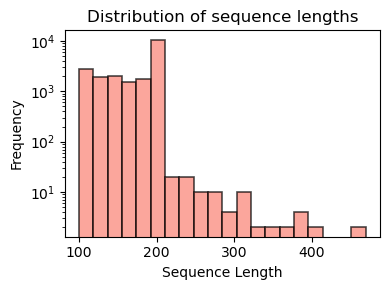

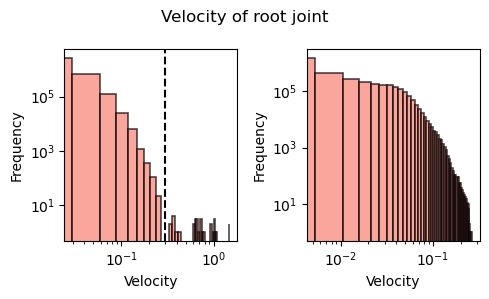

In [15]:
# Motion statistics
# Author: Anton Golles
# This script motion data for the following properties:
#   - Shape consistency
#   - Velocity
#   - Nan and zero values
# and then trims the data accordingly

import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
# path join 
from os.path import join as pjoin
from pathlib import Path

# load
def find_files(directory, extension):
    """Find all files in a directory with a specific extension."""
    return list(Path(directory).glob(f'*.{extension}'))

def load_npy_file(file_path):
    """Safely load a .npy file, returning None if an error occurs."""
    try:
        return np.load(file_path)
    except Exception as e:
        return None

def file_name_change(file, to_short=True):
    if to_short:
        
        # if its PosixPath change to string and the cut of the folder and extension
        # else just cut of the folder and extension
        return str(file).split('/')[-1].split('.')[0]

    else:
        # make it into the revelant PosixPath
        raise NotImplementedError

# checks
def shape_consistency_check(files, min_frames=10, verbose=True, plot=False, **kwargs):
    """Check the shape consistency of .npy files and identify files with fewer than min_frames."""
    #if verbose: logging.info('Checking shape consistency...')
    valid_shapes, bad_files = [], []
    
    for file in files:
        data = load_npy_file(file)
        if data is None or data.shape[0] < min_frames or len(data.shape) != 3:
            bad_files.append(file)
        else:
            valid_shapes.append(data.shape[0])

    if plot:
        # print('Making plot')
        plt.figure(figsize=(4, 3))
        plt.hist(valid_shapes, bins=20, edgecolor='black', linewidth=1.2, facecolor='salmon', alpha=0.7)
        plt.title('Distribution of sequence lengths')
        plt.xlabel('Sequence Length')
        plt.ylabel('Frequency')
        plt.yscale('log')
        plt.tight_layout()
        plt.savefig('assets/sequence_length_distribution.png')

    
    return [file.name for file in bad_files]

def check_velocity(data, threshold=0.5, root_idx = 0):
    """Check if the velocity of the root joint exceeds a threshold."""
    # print(data.shape)
    root_traversal = data[:, root_idx, :]
    # print(root_traversal.shape)
    # print(root_traversal.shape)
    velocity = np.linalg.norm(np.diff(root_traversal, axis=0), axis=1)
    return (velocity > threshold).any(), velocity

def check_velocity_all(files, threshold=.5, root_idx = 0, plot=False, **kwargs):
    """Check if the velocity of the root joint exceeds a threshold for all files."""
    bad_files = []
    velocities = {'good': [], 'bad': []}
    for file in files:
        data = load_npy_file(file)
        if data is not None:
            exceeds_threshold, velocity = check_velocity(data, threshold, root_idx)
            if exceeds_threshold:
                bad_files.append(file)
                velocities['bad'].append(velocity)
            else:
                velocities['good'].append(velocity)

    velocities['all'] = velocities['good'] + velocities['bad']
    for k, v in velocities.items():
        velocities[k] = np.hstack(v, ) if len(v) > 0 else np.array([])

    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(5, 3))
        ax[0].hist(velocities['all'], bins=50, edgecolor='black', linewidth=1.2, facecolor='salmon', alpha=0.7)
        ax[1].hist(velocities['good'], bins=50, edgecolor='black', linewidth=1.2, facecolor='salmon', alpha=0.7)
        for a in ax:
            a.set_yscale('log')
            a.set_xscale('log')
            a.set_ylabel('Frequency')
            a.set_xlabel('Velocity')
                
        ax[0].axvline(threshold, c='black', linestyle='--')
        fig.suptitle('Velocity of root joint')

        plt.tight_layout()
        plt.savefig('assets/velocity_of_root_joint.png')


    return bad_files

def nan_zero_check(files, verbose=False, plot=True, **kwargs):
    if verbose: print('-----------------------\nChecking for nan and zero values:')
    # check for nan values or zeros
    nan_count = 0
    zero_count = 0
    bad_files = []
    for f in files:
        data = np.load(f)
        nan_count_inc = np.isnan(data).sum() > 0
        zero_count_inc = (data == 0).sum() > 3
        if nan_count_inc:
            nan_count += 1
            bad_files.append(f)
        if zero_count_inc:
            zero_count += 1
            bad_files.append(f)

    if verbose:
        print('Number of nan values:', nan_count)
        print('Number of zero values:', zero_count)
        print('Files with nan or zero values:', bad_files)
        print('-----------------------')

    if plot:
        pass

    return bad_files

# remove files
def remove_from_lst(files, bad_files):            
    len_before = len(files)
    files = [str(f).split('/')[-1].split('.')[0] for f in files]
    # print(files)
    bad_files = [str(f).split('/')[-1].split('.')[0] for f in bad_files]
    # print(bad_files)
       
    files_reduced = [f for f in files if f not in bad_files]

    files_reduced = [pjoin(path, f+'.npy') for f in files_reduced]
    # len_after = len(files_reduced)    
    return files_reduced#, len_before - len_after

def run_check(func, files, plot=False, **kwargs):
    bad_files = func(files, plot=plot, **kwargs)
    files = remove_from_lst(files, bad_files)
    print('After check:', func.__name__, len(files))
    return files

#  train test val
def get_train_test_val(base_path = 'HumanML3D/HumanML3D/', suffix = ''):
    # load text file
    paths = {i : f'{base_path}{i}{suffix}.txt' for i in ['train', 'val', 'test']}
    files_4_selection = {k : np.loadtxt(v, delimiter=',', dtype=str) for k, v in paths.items()}
    return files_4_selection

def trim_files_4_selection(files_4_selection, files):
    print(files[:5])
    files_4_selection = files_4_selection.copy()
    for k, v in files_4_selection.items():
        files_4_selection[k] = [f for f in v if f in files]
    return files_4_selection

def print_summary(files_4_selection, title='Summary'):
    lengths = {k : {k1 : len(files_4_selection[k][k1]) for k1 in files_4_selection[k]} for k in files_4_selection}
    
    # include sum
    for k in lengths:
        lengths[k]['sum'] = sum(lengths[k].values())
    # print(lengths)
    keys = list(lengths[list(lengths.keys())[0]].keys())

    text = title.title()+':'+'\n'
    
    text += f' '*16 + '\t'.join([k for k in keys]) + '\n'
    for k, v in lengths.items():
        text += f'{str(k).rjust(10)}:\t' + '\t'.join([str(v[k1]) for k1 in keys]) + '\n'

    print(text)
    
if __name__ == '__main__':
    base_path = 'HumanML3D/HumanML3D/'
    path = pjoin(base_path,  'new_joints/')
    files = find_files(path, 'npy')
    print('After get filelist: len(files)' , len(files))
    # run checks
    for check in [shape_consistency_check, nan_zero_check, 
                  check_velocity_all
                  ]:
        files = run_check(check, files, plot=True, threshold=0.3, root_idx=0, min_frames=100)

    # get train test val
    files = [file_name_change(f, to_short=True) for f in files]
    files_4_selection = {'raw': get_train_test_val()}
    files_4_selection['trimmed'] = trim_files_4_selection(files_4_selection['raw'], files)
    print_summary(files_4_selection)
    files_4_selection = files_4_selection['trimmed']

    # save new files
    for k, v in files_4_selection.items():
        np.savetxt(f'{base_path}{k}_cleaned.txt', v, delimiter=',', fmt='%s')


## Text descriptions

Before Trimming:
                train	val	test	sum
       raw:	16429	1046	3064	20539

['011439', 'M004717', '013548', 'M014262', 'M000217']
Summary:
                train	val	test	sum
       raw:	16429	1046	3064	20539
   trimmed:	2965	192	588	3745



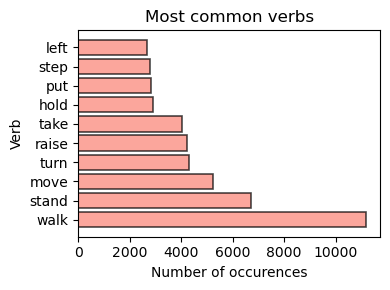

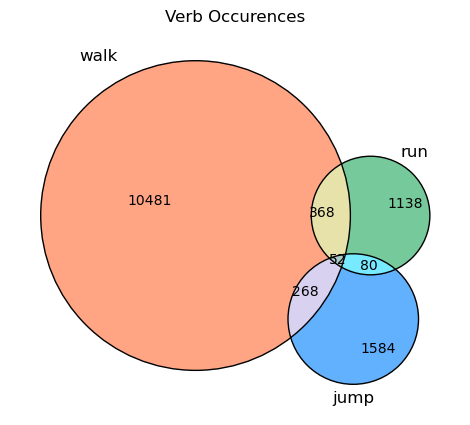

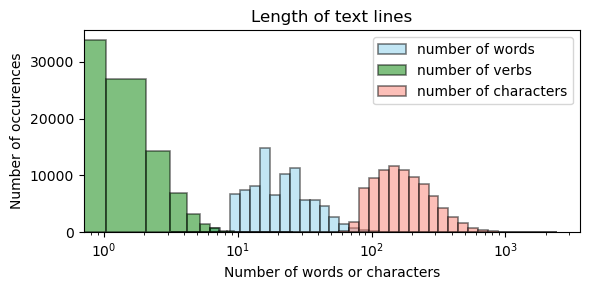

In [14]:
# look for verbs in text files
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_texts(path = 'HumanML3D/HumanML3D/texts/'):
    files = glob.glob(path + '*.txt')
    dic = {
        # file : [text line 0, text line 1, ...]
    }
    idx = 0
    for file in files:
        with open(file, 'r') as f:
            small_dic = {}
            file = file.split('/')[-1].split('.')[0]
            mirorred = False
            if file[0] == 'M' : mirorred = True
            small_dic['full_name'] = file
            small_dic['name'] = file[1:] if mirorred else file
            small_dic['mirorred'] = mirorred

            
            
            lines = f.readlines()
            verbs = []
            for n, line in enumerate(lines):
                line = line.strip()    
                small_dic[f'line_{n}'] = line
                words = line.replace('#', ' ').split(' ')
                for word in words:
                    if 'VERB'.lower() in word.lower():
                        word = word.replace('/VERB', '')
                        verbs.append(word)

            small_dic['verbs'] = set(verbs)
            
            dic[idx] = small_dic

            idx += 1


    df = pd.DataFrame(dic).T
    return df

def get_verb_counts(df, plot=False, top_n=10):
    verbs = {}
    for v in df['verbs']:
        for verb in v:
            verbs[verb] = verbs.get(verb, 0) + 1

    verbs = {k: v for k, v in sorted(verbs.items(), key=lambda item: item[1], reverse=True)}

    if plot:        
        # plot the most common verbs
        plt.figure(figsize=(4, 3))
        plt.barh(list(verbs.keys())[:top_n], list(verbs.values())[:top_n], color='salmon', edgecolor='black', linewidth=1.2, alpha=0.7)
        plt.xlabel('Number of occurences')
        plt.ylabel('Verb')
        plt.title('Most common verbs')
        plt.tight_layout()
        plt.savefig('assets/most_common_verbs.png')

    return verbs

def plot_verb_venn(df):
    df['is_walk'] = df['verbs'].apply(lambda x: 'walk' in x)
    df['is_run'] = df['verbs'].apply(lambda x: 'run' in x)
    df['is_jump'] = df['verbs'].apply(lambda x: 'jump' in x)

    def get_data_for_venn(df, verb_cols=['is_walk', 'is_run', 'is_jump']):
        '''
        The order is like:
            only A, 
            only B, 
            both, 
            only C, 
            A and C, 
            B and C, 
            A and B and C
        '''
        dic = {
            'Only A' : df[(df[verb_cols[0]] == True) & (df[verb_cols[1]] == False) & (df[verb_cols[2]] == False)].shape[0],
            'Only B' : df[(df[verb_cols[0]] == False) & (df[verb_cols[1]] == True) & (df[verb_cols[2]] == False)].shape[0],
            'Both' : df[(df[verb_cols[0]] == True) & (df[verb_cols[1]] == True) & (df[verb_cols[2]] == False)].shape[0],
            'Only C' : df[(df[verb_cols[0]] == False) & (df[verb_cols[1]] == False) & (df[verb_cols[2]] == True)].shape[0],
            'A and C' : df[(df[verb_cols[0]] == True) & (df[verb_cols[1]] == False) & (df[verb_cols[2]] == True)].shape[0],
            'B and C' : df[(df[verb_cols[0]] == False) & (df[verb_cols[1]] == True) & (df[verb_cols[2]] == True)].shape[0],
            'A and B and C' : df[(df[verb_cols[0]] == True) & (df[verb_cols[1]] == True) & (df[verb_cols[2]] == True)].shape[0],
            }

        return list(dic.values())

    # make venn diagram of df.value_counts(['is_walk', 'is_run', 'is_jump'])

    from matplotlib_venn import venn3, venn3_circles
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(6, 5))
    v = venn3(subsets = get_data_for_venn(df, ['is_walk', 'is_run', 'is_jump']), 
        set_labels = ('walk', 'run', 'jump'),
            set_colors=('coral', 'mediumseagreen', 'dodgerblue'),
            alpha = .7,
            ax=ax,
            normalize_to=1.0)
    c = venn3_circles(subsets = get_data_for_venn(df, ['is_walk', 'is_run', 'is_jump']),
                    linestyle='solid', linewidth=1., color='black')

    plt.title('Verb Occurences')
    plt.savefig('assets/verb_occurences.png')

def plot_occurance_hist(df):

    def get_line_length(line):
        """
        Counts the numbers of characters, words and verbs in a line of text.
        """
        if type(line) == float:
            return 0, 0, 0
        if line == '':
            return 0, 0,0 
        num_words = len(line.split(' '))
        num_chars = len(line)
        num_verbs = len([word for word in line.split(' ') if 'VERB' in word])
        return num_words, num_chars, num_verbs

    # Lets do number of verbs per line


    df['line_0_num_words'], df['line_0_num_chars'], df['num_verbs_line_0']  = zip(*df['line_0'].apply(get_line_length))
    df['line_1_num_words'], df['line_1_num_chars'], df['num_verbs_line_1']  = zip(*df['line_1'].apply(get_line_length))
    df['line_2_num_words'], df['line_2_num_chars'], df['num_verbs_line_2']  = zip(*df['line_2'].apply(get_line_length))

    num_words_all = df['line_0_num_words'].to_list() + df['line_1_num_words'].to_list() + df['line_2_num_words'].to_list()
    num_chars_all = df['line_0_num_chars'].to_list() + df['line_1_num_chars'].to_list() + df['line_2_num_chars'].to_list()
    num_verbs_all = df['num_verbs_line_0'].to_list() + df['num_verbs_line_1'].to_list() + df['num_verbs_line_2'].to_list()

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    log_bins = np.logspace(0.5, max([np.log10(max(num_words_all)), np.log10(max(num_chars_all))]), 40)

    ax.hist(num_words_all, bins=log_bins,
            edgecolor='black', linewidth=1.2, facecolor='skyblue', alpha=0.5, label='number of words')


    ax.hist(num_verbs_all, bins=25,
                edgecolor='black', linewidth=1.2, facecolor='green', alpha=0.5, label='number of verbs')

    ax.set_ylabel('Number of occurences')
    ax.set_title('Length of text lines')

    ax.hist(num_chars_all, bins=log_bins,
            edgecolor='black', linewidth=1.2, facecolor='salmon', alpha=0.5, label='number of characters')
    ax.set_xlabel('Number of words or characters', color='black')

    ax.set_xscale('log')
    ax.legend(loc='upper right')

    plt.tight_layout()

    plt.savefig('assets/length_of_text_lines.png')

# select df where verb in most common N
def select_by_common_verbs(df, verbs, N=5):
    verbs = list(verbs.keys())[:N]
    df['is_common_verb'] = df['verbs'].apply(lambda x: any([verb in x for verb in verbs]))
    return df[df['is_common_verb'] == True]

def select_by_specific_verbs(df, specific_verbs=['walk', 'run', 'jump']):
    df['is_specific_verb'] = df['verbs'].apply(lambda x: any([verb in x for verb in specific_verbs]))
    return df[df['is_specific_verb'] == True]

def trim_files_4_selection_df(df):
    files_4_selection = {'raw': get_train_test_val(suffix='_cleaned')}
    print_summary(files_4_selection, title='Before trimming')
    files_4_selection['trimmed'] = trim_files_4_selection(files_4_selection['raw'], df['full_name'].to_list())
    print_summary(files_4_selection)
    files_4_selection = files_4_selection['trimmed']

    # save new files
    for k, v in files_4_selection.items():
        np.savetxt(f'{base_path}{k}_cleaned.txt', v, delimiter=',', fmt='%s')


if __name__ == '__main__':
    df = load_texts()  # runs in about 1.5 seconds
    verbs = get_verb_counts(df, plot=True, top_n=10)
    plot_verb_venn(df)
    plot_occurance_hist(df)

    df_common_verbs = select_by_common_verbs(df, verbs, N=5)
    df_specific_verbs = select_by_specific_verbs(df, specific_verbs=['turn'])
    trim_files_4_selection_df(df_specific_verbs)
